---

### Initial Analysis


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score
from sklearn.svm import SVR


df = pd.read_csv("dataset.csv")
print(f"Columns: {list(df.columns)}")
print(f"Numerical columns: \n{df.describe()}")

Columns: ['genero', 'estado_civil', 'zona_residencia', 'imc', 'fumador', 'class_etaria', 'custo']
Numerical columns: 
               imc          custo
count  2215.000000    2215.000000
mean     30.704199    6045.710971
std       6.425918    8354.316703
min       3.400000     487.200000
25%      26.150000    2042.200000
50%      30.400000    4050.700000
75%      34.700000    7176.300000
max      83.100000  180544.400000


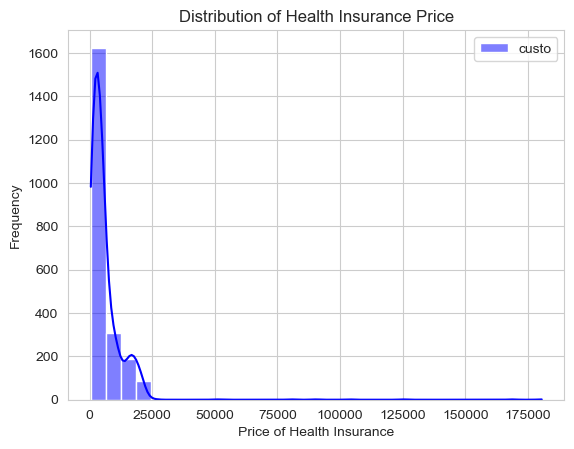

In [2]:
sns.set_style("whitegrid")
sns.histplot(data=df, x='custo', bins=30, kde=True, color='blue', label='custo')
plt.title('Distribution of Health Insurance Price')
plt.xlabel('Price of Health Insurance')
plt.ylabel('Frequency')
plt.legend()
plt.show()

---

### Target Analysis

Initially, we trained the model using the raw data, but the predictions consistently overestimated the target variable. To fix this, we analyzed the dataset more and noticed that:

- The distribution of the target variable (**`custo`**) is skewed, with some extreme values (e.g., **180,000**) much bigger than  the average value of **6,045**.
- We used a **Boxplot** to find outliers as values lying outside the whiskers.


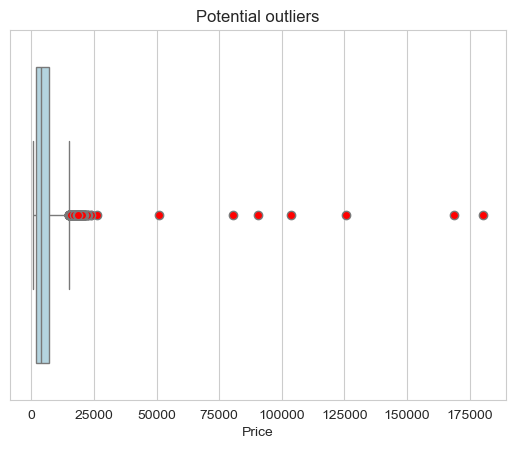

In [3]:
sns.boxplot(
    x=df['custo'],
    color='lightblue',
    flierprops={'markerfacecolor': 'red'}
)
plt.title('Potential outliers')
plt.xlabel('Price')
plt.show()

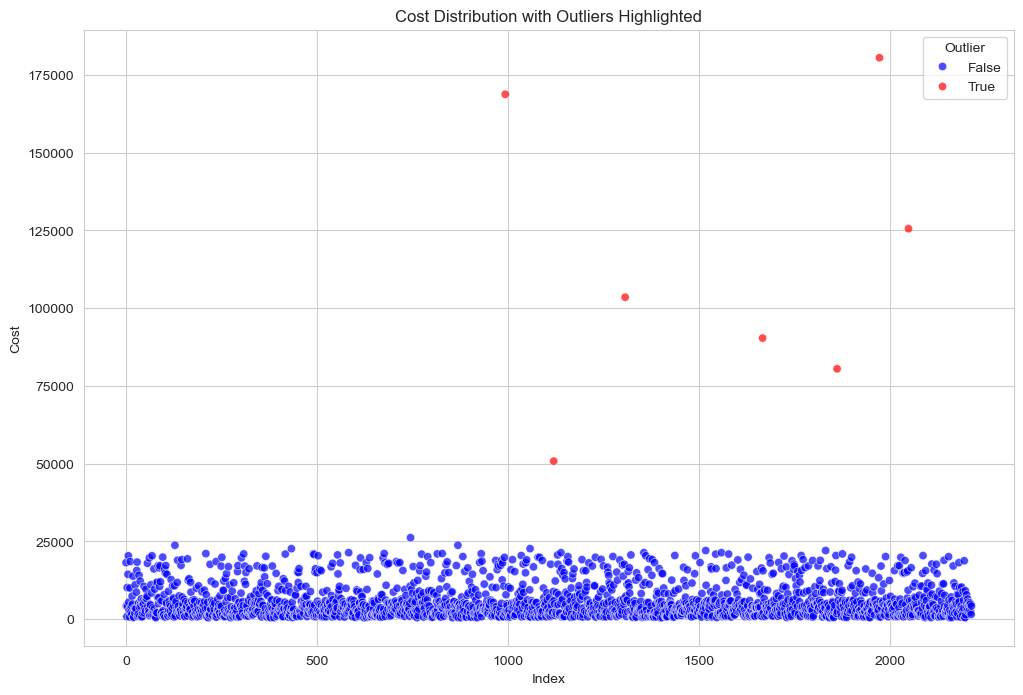

In [4]:
limit = 50000

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=df.index,
    y=df['custo'],
    hue=df['custo'] > limit,
    palette={False: 'blue', True: 'red'},
    alpha=0.7
)
plt.title("Cost Distribution with Outliers Highlighted")
plt.xlabel("Index")
plt.ylabel("Cost")
plt.legend(title="Outlier")
plt.show()

### Outlier Detection and Removal
We notice only **7 values** which are *extremely* out of the typical range, while the others are more concentrated near the upper bound. Therefore, we decide to *eliminate* them in order to reduce overestimating.

In [5]:
def remove_outliers(dframe, column, max_allowed):
    outliers_ind = dframe[dframe[column] > max_allowed].index
    return dframe.drop(outliers_ind).reset_index(drop=True)

df_cleaned = remove_outliers(df, 'custo', limit)

### Encoding Categorical Features
Seeing that we have categorical columns, we decide to encode them using **OneHotEncoder** to create binary columns for each category from each non-numeric field.

In [6]:

def encode_categorical_cols(X_en, categorical_cols):
    encoder = OneHotEncoder(sparse_output=False)
    encoded_dfs = []

    for col in categorical_cols:
        encoded = encoder.fit_transform(X_en[[col]])
        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([col]))
        encoded_dfs.append(encoded_df)

    X_en = X_en.drop(columns=categorical_cols)
    X_en = pd.concat([X_en] + encoded_dfs, axis=1)
    return X_en

X = df_cleaned.drop(columns=['custo'])
y = df_cleaned['custo']

categorical_columns = ['genero', 'estado_civil', 'zona_residencia', 'fumador', 'class_etaria']
X_encoded = encode_categorical_cols(X, categorical_columns)

---
### Data Splitting and Scaling
We split the data into **train and test sets**. After this, we scaled it using the **StandardScaler**.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=65)


def scale_data(scaler, train_data, test_data):
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)
    return train_scaled, test_scaled

scaler_x = StandardScaler()
X_train_scaled, X_test_scaled = scale_data(scaler_x, X_train, X_test)

scaler_y = StandardScaler()
y_train_scaled, y_test_scaled = scale_data(scaler_y, y_train.values.reshape(-1, 1), y_test.values.reshape(-1, 1))

---
### Parameter Search Strategy
First, we performed random searches (with **HalvingRandomSearchCV**) for good parameters using a much wider **param_grid**, and after noticing that most of the best results had similar parameters, we decided to use finer search to identify better params, now using a more thorough search: **HalvingGridSearchCV**.

In [8]:
def do_grid_search(estimator, parameter_grid, X_tr, y_tr):
    search = HalvingGridSearchCV(
        estimator=estimator,
        param_grid=parameter_grid,
        scoring='r2',
        n_jobs=-1,
        cv=5,
        verbose=0
    )
    search.fit(X_tr, y_tr)
    return search

svr = SVR()

# this narrow param_grid is used for finer tuning (params were obtained with random search)
param_grid = {
    'C': np.linspace(10, 12, 1000),
    'epsilon': [0.1],
    'gamma': ['scale'],
    'kernel': ['rbf']
}

grid_search = do_grid_search(svr, param_grid, X_train_scaled, y_train_scaled.ravel())
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

optimized_svr = grid_search.best_estimator_

Best Parameters: {'C': 10.024024024024024, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


### Test Prediction Results

Next, we made predictions, scaled them back and compared them with test target values. We got an **R2 score ~ 0.87**.

In [9]:
y_pred_scaled = optimized_svr.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2}")

R2 Score: 0.8727390222700286


### Comparing true vs prediction
To see the comparison between actual and predicted values, we used a *Density* plot (smoother than a histogram, easier to see differences).

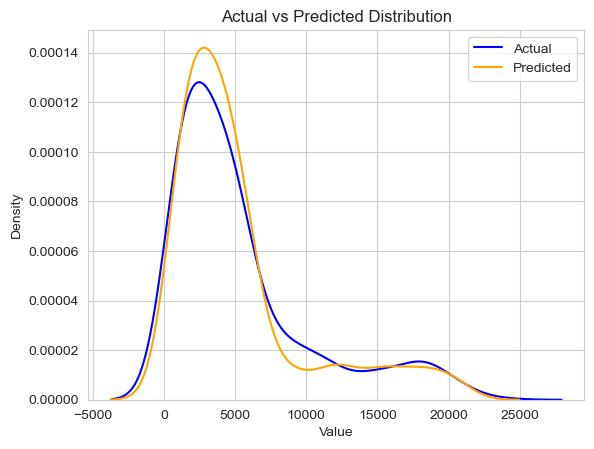

In [10]:
sns.kdeplot(y_test, label="Actual", color="blue")
sns.kdeplot(y_pred, label="Predicted", color="orange")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Actual vs Predicted Distribution")
plt.legend()
plt.show()

Looking at the above graph, we can see that it replicates the shape of the distribution of the true values pretty close, while still doing some over-estimating. Considering the nature of the Insurance Business, the majority of customers will overpay a little bit to compensate for some of the riskier customers.

---
### Feature importance

Next, we analyzed feature importance and identified that the most important one is whether the customer is **smoking**. (We used all features in our model, since when trying to use fewer of them we got worse results)

In [11]:
perm_importance = permutation_importance(
    optimized_svr,
    X_test_scaled,
    y_test_scaled.ravel(),
    scoring='r2',
    n_repeats=30,
    random_state=0
)

importances = perm_importance.importances_mean
importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature importance (using permutation importance):")
print(importance_df)



Feature importance (using permutation importance):
                           Feature  Importance
11                     fumador_sim    0.336849
10                     fumador_nao    0.336849
0                              imc    0.235704
16              class_etaria_idoso    0.088683
15      class_etaria_adulto_senior    0.075802
3              estado_civil_casado    0.028388
4            estado_civil_separado    0.022546
14  class_etaria_adulto_meia_idade    0.021747
17              class_etaria_jovem    0.021372
5            estado_civil_solteiro    0.021215
13       class_etaria_adulto_jovem    0.017361
6               estado_civil_viuvo    0.014965
8        zona_residencia_suburbana    0.009144
7            zona_residencia_rural    0.008273
12        class_etaria_adolescente    0.007846
9           zona_residencia_urbana    0.006558
2                 genero_masculino    0.003657
1                  genero_feminino    0.003657


---

### Final prediction
Next, we predicted the target values for the dataset just with features (encoded columns and scaled using the same x scaler), performed inverse transform to predictions and saved the final results to **csv file**.

In [12]:
new_customers = pd.read_csv('just_features.csv')
new_customers_encoded = encode_categorical_cols(new_customers, categorical_columns)
new_customers_scaled = scaler_x.transform(new_customers_encoded)

pred_costs_scaled = optimized_svr.predict(new_customers_scaled)
pred_costs = scaler_y.inverse_transform(pred_costs_scaled.reshape(-1, 1)).ravel()

def save_to_csv(predictions, filename):
    output = pd.DataFrame({'custo': predictions.round(1)})
    output.to_csv(filename, index=False)

save_to_csv(pred_costs, 'grupo42_custos_estimados.csv')